In [ ]:
!pip install yfinance pandas_ta pandas numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=488149a78174a0711d726a96a1922105e40a88dcf61087f41dd967a0ebbab8d4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-ee9508ae8cdc>:94: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['capital'].iloc[i] = capital
<ipython-input-13-ee9508ae8cdc>:94: SettingWithCopyWarni

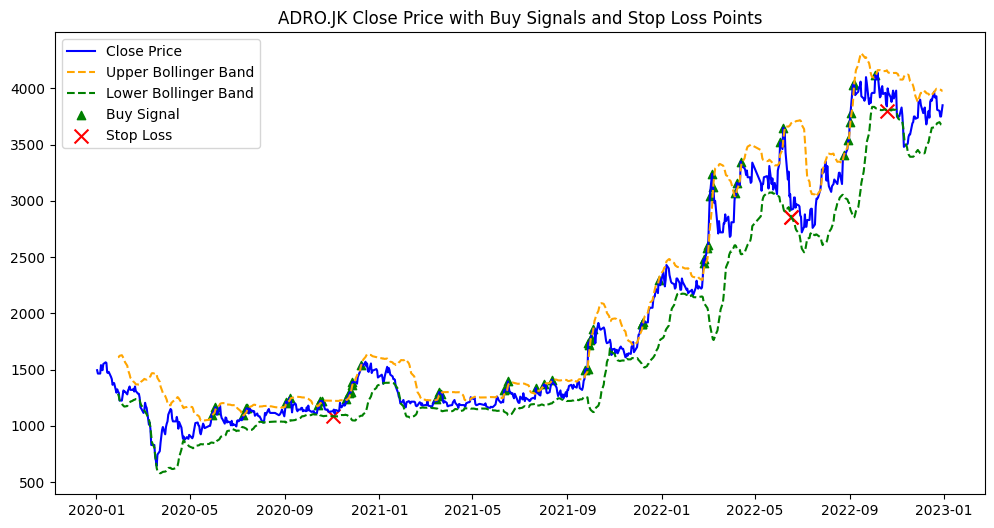

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

# Download historical data
ticker = 'ADRO.JK'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Calculate Bollinger Bands (20 period, 2 std deviation)
bollinger = ta.bbands(data['Close'], length=20, std=2)
data['upper_band'] = bollinger['BBU_20_2.0']
data['middle_band'] = bollinger['BBM_20_2.0']
data['lower_band'] = bollinger['BBL_20_2.0']

# Calculate Awesome Oscillator (AO)
data['ao'] = ta.ao(data['High'], data['Low'])

# Calculate Volume Moving Average (50 period)
data['vol_ma50'] = ta.sma(data['Volume'], length=50)

# Strategy Conditions
def buy_conditions(row):
    # Condition 1: Price breaks the upper Bollinger Band
    condition1 = row['Close'] > row['upper_band']

    # Condition 2: At least 6 of the last 10 AO histogram values are positive
    ao_last_10 = data['ao'].iloc[-10:]
    condition2 = np.sum(ao_last_10 > 0) >= 6

    # Condition 3: Volume is greater than the 50-period volume moving average
    condition3 = row['Volume'] > row['vol_ma50']

    return condition1 and condition2 and condition3

# Apply buy signal
data['buy_signal'] = data.apply(buy_conditions, axis=1)

# Track daily capital
data['capital'] = 100000  # Initial capital

# Define Stop Loss (at the lower Bollinger Band) and Take Profit (1:3 risk-reward ratio)
def calculate_trades(data):
    initial_capital = 100000  # Starting capital
    position_size = 0.1  # Invest 10% of capital per trade
    capital = initial_capital
    trades = []  # Store details of each trade
    stop_loss_points = []  # Store the stop loss points

    for i in range(len(data)):
        if data['buy_signal'].iloc[i]:
            # Buy at close price
            entry_price = data['Close'].iloc[i]
            stop_loss = data['lower_band'].iloc[i]
            take_profit = entry_price + 3 * (entry_price - stop_loss)

            # Simulate buying with position_size% of capital
            shares = (capital * position_size) / entry_price
            capital -= shares * entry_price

            # Initialize trade record
            trade = {
                'Entry Date': data.index[i],
                'Entry Price': entry_price,
                'Stop Loss': stop_loss,
                'Take Profit': take_profit,
                'Exit Date': None,
                'Exit Price': None,
                'Exit Reason': None
            }

            for j in range(i + 1, len(data)):
                # Check for stop loss or take profit
                if data['Low'].iloc[j] <= stop_loss:
                    exit_price = stop_loss
                    capital += shares * exit_price
                    trade['Exit Date'] = data.index[j]
                    trade['Exit Price'] = exit_price
                    trade['Exit Reason'] = 'stop_loss'
                    stop_loss_points.append(data.index[j])  # Record the stop loss date
                    trades.append(trade)
                    break
                elif data['High'].iloc[j] >= take_profit:
                    exit_price = take_profit
                    capital += shares * exit_price
                    trade['Exit Date'] = data.index[j]
                    trade['Exit Price'] = exit_price
                    trade['Exit Reason'] = 'take_profit'
                    trades.append(trade)
                    break

            # Track daily capital for every day
            data['capital'].iloc[i] = capital

    return capital, trades, stop_loss_points

# Run the backtest
final_capital, trades, stop_loss_points = calculate_trades(data)

# Plot Buy Signals and Stop Loss Points
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['upper_band'], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(data['lower_band'], label='Lower Bollinger Band', linestyle='--', color='green')

# Plot Buy Signals
plt.scatter(data.index[data['buy_signal']], data['Close'][data['buy_signal']], marker='^', color='green', label='Buy Signal')

# Plot Stop Loss Points
stop_loss_prices = data['lower_band'][stop_loss_points]  # Get stop loss price at the stop loss date
plt.scatter(stop_loss_points, stop_loss_prices, marker='x', color='red', label='Stop Loss', s=100)

plt.title(f'{ticker} Close Price with Buy Signals and Stop Loss Points')
plt.legend()
plt.show()


In [ ]:
# Display the metrics
print(f"Initial Capital: $100,000")
print(f"Final Capital: ${final_capital:.2f}")
# print(f"Total Trades Executed: {total_trades}")
# print(f"Winning Trades: {winning_trades}")
# print(f"Winning Percentage: {winning_percentage:.2f}%")
# print(f"Percentage Return: {final_return_percentage:.2f}%")

Initial Capital: $100,000
Final Capital: $243989.01


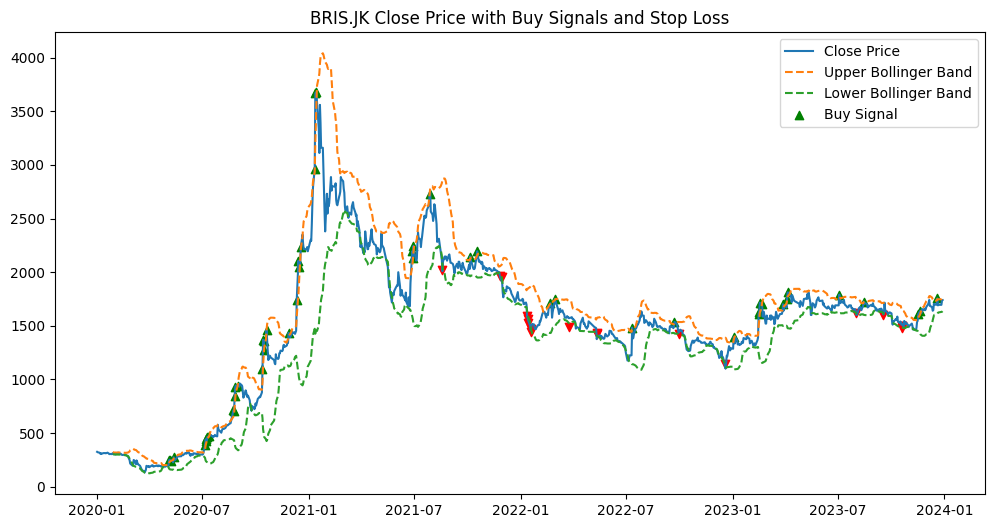

In [ ]:
# prompt: i want you to plot the stop loss point of the chart above with red triangle

# ... (Your existing code) ...

# Plot Buy Signals and Stop Loss Points
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['upper_band'], label='Upper Bollinger Band', linestyle='--')
plt.plot(data['lower_band'], label='Lower Bollinger Band', linestyle='--')
plt.scatter(data.index[data['buy_signal']], data['Close'][data['buy_signal']], marker='^', color='g', label='Buy Signal')

# Iterate through trades and plot stop loss points
for index, row in trades_df.iterrows():
    if row['Exit Reason'] == 'stop_loss':
        plt.scatter(row['Exit Date'], row['Stop Loss'], marker='v', color='r', label='Stop Loss' if index == 0 else None)


plt.title(f'{ticker} Close Price with Buy Signals and Stop Loss')
plt.legend()
plt.show()

# ... (Your existing code) ...
